In [23]:
import tensorflow_datasets as tfds
import tensorflow as tf

# TensorFlow Datasets를 사용하여 'tf_flowers' 데이터셋을 로드합니다.
# 'train' 데이터셋과 관련 정보를 함께 로드합니다.
dataset, info = tfds.load('tf_flowers', split='train', with_info=True)

In [24]:
# 이미지를 같은 크기로 formatting
IMG_SIZE = 160

# 데이터 전처리를 위한 함수입니다.
def tf_format_example(data):
    # 이미지를 float32 자료형으로 변환합니다.
    image = tf.cast(data['image'], tf.float32)
    # 이미지를 0~1 사이의 값으로 정규화합니다.
    image = (image/255.0)
    # 이미지 크기를 IMG_SIZE로 조정합니다.
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    # 라벨을 가져옵니다.
    label = data['label']
    return image, label

# 데이터셋을 로드합니다. 이번에는 전체 데이터셋을 로드합니다.
dataset, info = tfds.load('tf_flowers', split='train', with_info=True)

# tf_format_example 함수를 이용하여 데이터셋을 전처리합니다.
dataset = dataset.map(tf_format_example)

# 전체 데이터셋의 크기를 확인합니다.
num_examples = info.splits['train'].num_examples
# 훈련 데이터셋의 크기를 계산합니다.
train_size = int(0.8 * num_examples)
# 검증 데이터셋의 크기를 계산합니다.
val_size = int(0.1 * num_examples)
# 테스트 데이터셋의 크기를 계산합니다.
test_size = num_examples - train_size - val_size

# 훈련 데이터셋을 생성합니다.
train_dataset = dataset.take(train_size)
# 남은 데이터셋에서 검증 데이터셋을 생성합니다.
remaining_dataset = dataset.skip(train_size)
validation_dataset = remaining_dataset.take(val_size)
# 남은 데이터셋에서 테스트 데이터셋을 생성합니다.
test_dataset = remaining_dataset.skip(val_size)

# 데이터 증강을 위한 함수입니다.
def tf_augment_example(image, label):
    # 무작위로 좌우로 뒤집기
    image = tf.image.random_flip_left_right(image)
    return image, label

# 데이터셋에 데이터 증강 함수를 적용합니다.
train_dataset = train_dataset.map(tf_augment_example)

# 훈련 데이터셋을 섞고 배치 단위로 나눕니다.
train_batches = train_dataset.shuffle(100).batch(32)
# 검증 데이터셋을 배치 단위로 나눕니다.
validation_batches = validation_dataset.batch(32)
# 테스트 데이터셋을 배치 단위로 나눕니다.
test_batches = test_dataset.batch(32)

In [25]:
# MobileNetV2 모델을 생성합니다.
model = tf.keras.Sequential([
    tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [26]:
# 모델 컴파일
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# 모델 학습
history = model.fit(train_batches,
                    epochs=10,
                    validation_data=validation_batches)

Epoch 1/10
92/92 [==============================] - 29s 274ms/step - loss: 0.5578 - accuracy: 0.8018 - val_loss: 4.7109 - val_accuracy: 0.7030
Epoch 2/10
92/92 [==============================] - 25s 273ms/step - loss: 0.3922 - accuracy: 0.8804 - val_loss: 6.9237 - val_accuracy: 0.5204
Epoch 3/10
92/92 [==============================] - 25s 266ms/step - loss: 0.2899 - accuracy: 0.8954 - val_loss: 17.5786 - val_accuracy: 0.2779
Epoch 4/10
92/92 [==============================] - 25s 266ms/step - loss: 0.2676 - accuracy: 0.9135 - val_loss: 8.3479 - val_accuracy: 0.4251
Epoch 5/10
92/92 [==============================] - 25s 269ms/step - loss: 0.2154 - accuracy: 0.9240 - val_loss: 10.8004 - val_accuracy: 0.3706
Epoch 6/10
92/92 [==============================] - 25s 268ms/step - loss: 0.1743 - accuracy: 0.9414 - val_loss: 3.9979 - val_accuracy: 0.5395
Epoch 7/10
92/92 [==============================] - 25s 268ms/step - loss: 0.1528 - accuracy: 0.9462 - val_loss: 6.5329 - val_accuracy: 0.49

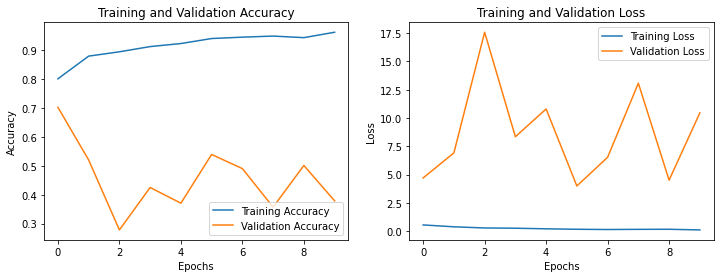

12/12 [==============================] - 4s 63ms/step - loss: 10.4546 - accuracy: 0.3787
Validation Loss: 10.45
Validation Accuracy: 37.87%
12/12 [==============================] - 4s 65ms/step - loss: 10.0114 - accuracy: 0.3460
Test Loss: 10.01
Test Accuracy: 34.60%


In [27]:
# 학습 과정 시각화
import matplotlib.pyplot as plt

def plot_accuracy_loss(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.show()

# 정확도와 손실 값을 그래프로 출력합니다.
plot_accuracy_loss(history)

# 검증 데이터셋에서의 손실과 정확도를 평가합니다.
loss, accuracy = model.evaluate(validation_batches)
print("Validation Loss: {:.2f}".format(loss))
print("Validation Accuracy: {:.2f}%".format(accuracy * 100))

# 테스트 데이터셋에서의 손실과 정확도를 평가합니다.
loss, accuracy = model.evaluate(test_batches)
print("Test Loss: {:.2f}".format(loss))
print("Test Accuracy: {:.2f}%".format(accuracy * 100))

In [28]:
import numpy as np

# 테스트 데이터셋에서 이미지 배치와 라벨 배치를 가져옵니다.
for image_batch, label_batch in test_batches:
    break

# 모델을 사용하여 이미지 배치의 예측값을 가져옵니다.
predictions = model.predict(image_batch)

# 예측값에서 가장 높은 확률을 가지는 라벨을 선택합니다.
predicted_labels = np.argmax(predictions, axis=1)
# 실제 라벨을 가져옵니다.
true_labels = label_batch.numpy()

# 각 이미지에 대한 예측값과 실제 라벨을 출력합니다.
for i in range(len(predicted_labels)):
    print("Predicted label: ", predicted_labels[i])
    print("True label: ", true_labels[i])
    print()

Predicted label:  1
True label:  1

Predicted label:  2
True label:  2

Predicted label:  1
True label:  4

Predicted label:  1
True label:  2

Predicted label:  1
True label:  4

Predicted label:  0
True label:  0

Predicted label:  0
True label:  0

Predicted label:  1
True label:  0

Predicted label:  0
True label:  0

Predicted label:  1
True label:  2

Predicted label:  1
True label:  4

Predicted label:  1
True label:  3

Predicted label:  1
True label:  2

Predicted label:  1
True label:  4

Predicted label:  1
True label:  4

Predicted label:  0
True label:  1

Predicted label:  3
True label:  3

Predicted label:  1
True label:  3

Predicted label:  1
True label:  2

Predicted label:  1
True label:  1

Predicted label:  0
True label:  0

Predicted label:  1
True label:  0

Predicted label:  1
True label:  2

Predicted label:  1
True label:  2

Predicted label:  1
True label:  2

Predicted label:  1
True label:  2

Predicted label:  1
True label:  1

Predicted label:  1
True lab

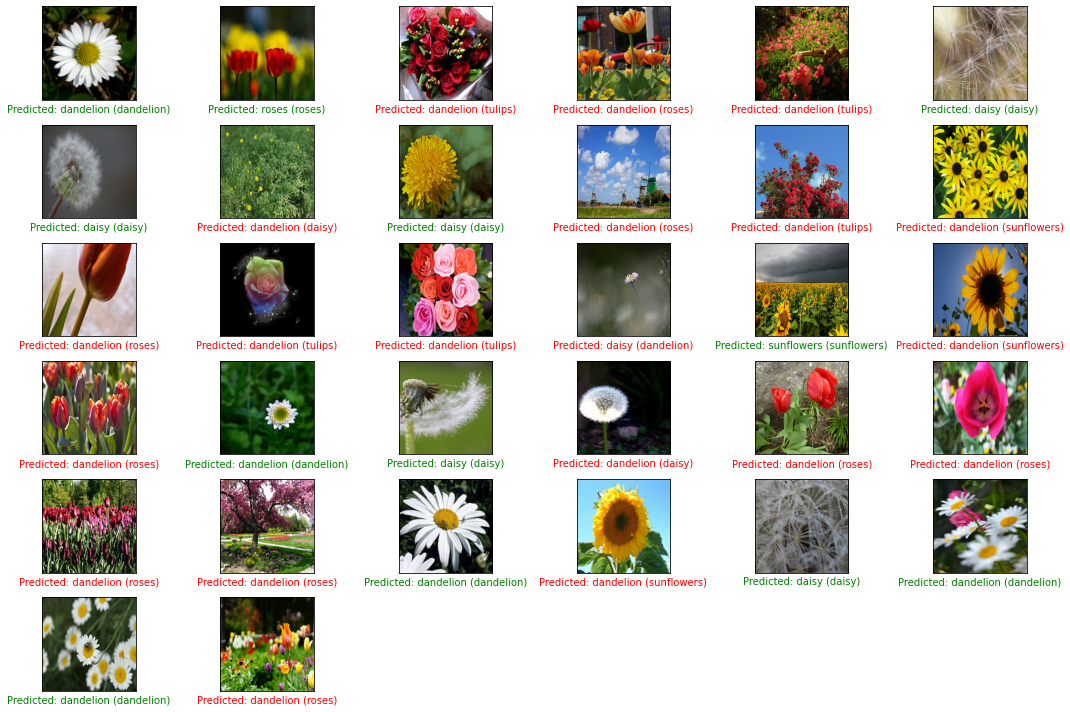

In [29]:
# 이미지, 라벨, 예측값을 시각화하는 함수
def visualize_images(images, labels, predictions):
    class_names = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
    num_images = len(images)

    # 이미지 개수에 따라 적절한 행과 열을 계산합니다.
    rows = int(np.ceil(np.sqrt(num_images)))
    cols = int(np.ceil(num_images / rows))

    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(rows, cols, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        predicted_label = np.argmax(predictions[i])
        true_label = labels[i]
        if predicted_label == true_label:
            color = 'green'
        else:
            color = 'red'
        plt.xlabel("Predicted: {} ({})".format(class_names[predicted_label], 
                                                class_names[true_label]), color=color)

    plt.tight_layout()
    plt.show()

# 이미지, 라벨, 예측값을 가져옵니다.
images = image_batch.numpy()
labels = true_labels

# 시각화 함수를 호출하여 이미지, 라벨, 예측값을 시각화합니다.
visualize_images(images, labels, predictions)

In [30]:
# 이미지, 라벨, 예측값을 가져옵니다.
images = image_batch.numpy()
labels = true_labels

# 예측의 개수를 초기화합니다.
correct_predictions = 0

# 이미지 개수만큼 반복하면서 예측값과 실제 라벨을 비교합니다.
for i in range(len(images)):
    predicted_label = np.argmax(predictions[i])
    true_label = labels[i]
    if predicted_label == true_label:
        correct_predictions += 1

# 정확도(accuracy)를 계산합니다.
accuracy = correct_predictions / len(images)

# 정확도를 출력합니다.
print("Accuracy: {:.2%}".format(accuracy))

Accuracy: 37.50%
